In [43]:
#add helper functions
import sys
sys.path.insert(0,'C:/MyDevelopment/Goalscorers')
from helper_functions import *

import pandas as pd
import scipy
import glob
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import os
from sklearn.metrics import r2_score
from scipy.stats import binom, poisson, nbinom, expon, gamma
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
import warnings
import statsmodels.api as sm
from sklearn import linear_model

In [88]:
npxg_train_preds = pd.read_csv("C:/MyDevelopment/Goalscorers/model_results/npxg_train_predictions.csv")
npxg_val_preds = pd.read_csv("C:/MyDevelopment/Goalscorers/model_results/npxg_test_predictions.csv")

In [89]:
data = pd.read_csv("clean_data/event_data_with_exps.csv")

In [90]:
data = data[data["league_name"] == 'Premier League']

In [91]:
data[["league_name","season"]].value_counts().sort_index()

league_name     season   
Premier League  2017-2018    10448
                2018-2019    10480
                2019-2020    10614
                2020-2021    10393
                2021-2022    10485
                2022-2023    11345
dtype: int64

In [92]:
#remove matches where there more than 2 goalkeeper per team
result = data[data['position_mapped'] == 'GK'].groupby(['date', 'home_team', 'away_team'], as_index=False).size()
result = result[result["size"] == 2]
result = result.drop(["size"],axis=1)

#merge with data to filter out these matches
data = pd.merge(data, result, on=['date', 'home_team', 'away_team'])

In [93]:
# #remove rows with null values in npxg or in minutes player
data = data[~data.npxg.isnull()]
data = data[~data.minutes.isnull()]

#get opposing goalkeeper as a feature
prev_shape = data.shape[0]
df_gk = data[data["position_mapped"] == 'GK'][["datetime", "home_team", "away_team", "squad", "player"]]
data = data.merge(df_gk,on=["datetime", "home_team", "away_team"], suffixes=('', '_gk'))
data = data[data.squad != data.squad_gk]
data = data.drop(["squad_gk"],axis=1)
data = data.rename(columns={'player_gk':'gk_opp'})
assert(prev_shape == data.shape[0])

#remove goalkeepers
data = data[data["position_mapped"] != 'GK']

#get goal supremacy feature
data["supremacy"] = data["goal_exp"] - data["goal_exp_opp"]

#convert datetime to pd.datetime column
data["datetime"] = pd.to_datetime(data.datetime)

#create year and week columns
data["year"] = data["datetime"].dt.isocalendar().year
data["week"] = data["datetime"].dt.isocalendar().week


data["npg"] = data.goals - data.pens_made
data.npxg = np.where((data.npg !=0) & (data.npxg == 0), 0.03, data.npxg)#map npxg to >0
data.npxg = data.npxg.transform(lambda x: 0.01 if x == 0 else x)

#data
data = data.sort_values(["year","week"])

#get cummulative count of player observations
data['n_prev_observations'] = data.groupby('player').cumcount()

In [94]:
xg_data = data.groupby(["player"], as_index=False)[["npxg","npg"]].sum()
xg_data["conv_rate"] = xg_data.npg / xg_data.npxg
xg_data = xg_data.sort_values(["conv_rate"], ascending = False)

In [95]:
xg_gk_data = data.groupby(["gk_opp"], as_index=False)[["npxg","npg"]].sum()
xg_gk_data["conv_rate"] = xg_gk_data.npg / xg_gk_data.npxg
xg_gk_data = xg_gk_data.sort_values(["conv_rate"], ascending = True)

In [96]:
npxg_train_preds.columns

Index(['date', 'squad', 'player', 'expectancies', 'scale', 'shape', 'target',
       'datetime', 'position_mapped', 'start', 'npxg', 'npg'],
      dtype='object')

In [97]:
data = data[["date", "squad", "player", "gk_opp", "year", "week"]]
npxg_train_data = pd.merge(npxg_train_preds, data, on=["date", "squad", "player"])
npxg_val_data = pd.merge(npxg_val_preds, data, on=["date", "squad", "player"])

assert(len(npxg_train_data) <= len(npxg_train_preds))
assert(len(npxg_val_data) <= len(npxg_val_preds))

In [98]:
npxg_train_data.head()

,date,squad,player,expectancies,scale,shape,target,datetime,position_mapped,start,npxg,npg,gk_opp,year,week
0,2018-08-10,Manchester United,Marcus Rashford,0.154537,0.696328,0.221931,0.0001,2018-08-10 19:00:00,FW,True,0.0001,0,Kasper Schmeichel,2018,32
1,2018-08-10,Manchester United,Alexis Sánchez,0.163566,0.737013,0.221931,0.0001,2018-08-10 19:00:00,W,True,0.0001,0,Kasper Schmeichel,2018,32
2,2018-08-10,Manchester United,Juan Mata,0.156174,0.703705,0.221931,0.1000,2018-08-10 19:00:00,W,True,0.1000,0,Kasper Schmeichel,2018,32
3,2018-08-10,Manchester United,Paul Pogba,0.118451,0.533730,0.221931,0.0001,2018-08-10 19:00:00,CM,True,0.0001,0,Kasper Schmeichel,2018,32
4,2018-08-10,Manchester United,Andreas Pereira,0.072147,0.325086,0.221931,0.0001,2018-08-10 19:00:00,CM,True,0.0001,0,Kasper Schmeichel,2018,32


In [123]:
features_to_use = [
    "expectancies",
    "player",
    "gk_opp"
]

target_var = 'npg'
encoding_dict = {'player':(None, 'pl'), 'gk_opp':('first', "gk")}
categorical_vars = ["player","gk_opp"]

In [124]:
def feature_mapping_function(x_train,x_val, encoding_dict):
    x_train["expectancies_log"] = np.log(x_train.expectancies)
    x_val["expectancies_log"] = np.log(x_val.expectancies)
    
    x_train = x_train.drop(["expectancies"], axis=1)
    x_val = x_val.drop(["expectancies"], axis=1)
    
    #one hot encode x_train and x_test
    x_train, encoder = one_hot_encode_data(x_train, encoding_dict=encoding_dict)
    x_val, _ = one_hot_encode_data(x_val, encoding_dict=encoding_dict, preprocessor=encoder)
    
    #multiply npxg by OHE variables and drop npxg col
    x_train = x_train.multiply(x_train["expectancies_log"], axis="index")
    x_train.expectancies_log = np.sqrt(x_train.expectancies_log)
    
    x_val = x_val.multiply(x_val["expectancies_log"], axis="index")
    x_val.expectancies_log = np.sqrt(x_val.expectancies_log)
    
    return x_train, x_val    

In [140]:
#get consecutive week train-evaluation
def get_consecutive_evaluations(pre_train_dat,dat, decay_factor, reg_param, features_to_use,target_var,
                                cat_vars, encoding_dict, distribution, fit_intercept=False, lower_thresh=0,verbose=False,
                                feature_mapping_func=None):

    df = dat.copy()
    df = df.sort_values(["year", "week"])
    grouped = df.groupby(["year", "week"], as_index = False)
    if distribution == "Gamma":
        cols = ["date","squad", "player","expectancies", "scale","shape", "target"]
    elif distribution == "Poisson":
        cols = ["date","squad", "player","expectancies","target"]
    else:
        raise Exception("Invalid distribution argument.")
        
    exps = pd.DataFrame(columns=cols)
    coefficient_information = []
    counter = 0
    total_samples = 0
    
    for i,_ in grouped:
        if counter >= lower_thresh:
            year = i[0]
            week = i[1]
            if verbose == True:
                print(f"Year = {year}, week = {week}...")

            #split validation data by week
            val_train, val_test = split_dataset(df, year, week)
            if pre_train_dat is None:
                data_to_train = val_train
            else:
                data_to_train = pd.concat([pre_train_dat, val_train], axis = 0)
            
            if decay_factor != None:
                week_diff = get_week_difference(data_to_train, year, week)
                weights = get_weights(week_diff, decay_factor)
            else:
                weights = None
            
            #get x_train,x_test,y_train,y_test
            x_train = data_to_train[features_to_use].reset_index(drop=True)
            y_train = data_to_train[target_var].values

            x_test = val_test[features_to_use].reset_index(drop=True)
            y_test = val_test[target_var].values
            
            #preprocessing:
            if feature_mapping_func is None:
                #standardize
                x_train, scaler = standardize(x_train, cat_vars=cat_vars)
                x_test, _ = standardize(x_test, cat_vars=cat_vars, scaler=scaler)

                #one hot encode x_train and x_test
                x_train, encoder = one_hot_encode_data(x_train, encoding_dict=encoding_dict)
                x_test, _ = one_hot_encode_data(x_test, encoding_dict=encoding_dict, preprocessor=encoder)

                #add constants if fit_intercept == True
                if fit_intercept == True:
                    x_train = sm.add_constant(x_train)
                    x_test = sm.add_constant(x_test)
                    
            else:
                x_train, x_test = feature_mapping_func(x_train,x_test, encoding_dict)

            #get features
            features = x_train.columns
            
            #train model
            if distribution=="Gamma":
                model = linear_model.GammaRegressor(fit_intercept=False, alpha = reg_param, max_iter = 500)
                model.fit(x_train, y_train, sample_weight = weights)
                
                train_preds = model.predict(x_train)
                preds = model.predict(x_test)
                #get in-sample shape parameter
                inv_shape_param =  estimate_x2_scale(y_train, train_preds, len(x_train), len(features))
                shape_from_model = 1/inv_shape_param

                scales = [m_i /shape_from_model for m_i in preds]

                ids = val_test[["date","squad", "player"]].reset_index(drop=True)
                ids["expectancies"] = preds
                ids["scale"] = scales
                ids["shape"] = shape_from_model
                
            elif distribution == "Poisson":
                model = linear_model.PoissonRegressor(fit_intercept=False, alpha = reg_param, max_iter = 500)
                model.fit(x_train, y_train, sample_weight = weights)
                
                preds = model.predict(x_test)
                ids = val_test[["date","squad", "player"]].reset_index(drop=True)
                ids["expectancies"] = preds
                
            else:
                raise Exception("Invalid distribution arg.")
                                
            coefs = model.coef_
            coef_dict = dict(zip(features, coefs))
            coefficient_information.append(coef_dict)
            ids["target"] = y_test
            
            exps = pd.concat([exps, ids], axis = 0)
            n_samples_train = len(x_train)
            n_samples_test = len(x_test)
            total_samples += n_samples_test 
            
        counter += 1

    print(f"total val samples = {total_samples}")
    return exps, coefficient_information

In [176]:
def tune_hyperparameters(dat,reg_grid, decay_grid, features_to_use,target_var,
                         cat_vars, encoding_dict, distribution, fit_intercept, feature_mapping_func=None,
                         verbose=False,lower_thresh=5):
    
    grid_scores = []
    for reg in reg_grid:
        for dec in decay_grid:
            print(f"Trying reg={reg} and decay factor = {dec}")
            
            model_results, _ = get_consecutive_evaluations(None,dat, dec, reg,features_to_use,target_var,
                                                        cat_vars,encoding_dict,distribution, fit_intercept, lower_thresh,
                                                        verbose,feature_mapping_func)
            
            
            if distribution == "Gamma":
                params = (model_results.scale, model_results["shape"])
            else:
                params = (model_results.expectancies,)

            model_results.target = model_results.target.astype("float")
            llres, avg_llres = get_log_likelihood(model_results.target,
                                       params, 
                                       distribution=distribution,
                                       individual_scores=False)
            
            r2score  = r2_score(model_results.target, model_results.expectancies)
            grid_scores.append((reg, dec, r2score, llres, avg_llres))
            
    grid_scores = pd.DataFrame(grid_scores, columns=["reg_parameter","decay_parameter","r2score","logl_exp","avg_logl_exp"])
    return grid_scores

In [177]:
reg_grid = [0.001, 0.01, 0.1]
decay_grid = [0.001,0.005,0.01,0.05,0.1]
grid_scores = tune_hyperparameters(npxg_train_data,reg_grid, decay_grid, features_to_use,target_var,
                         categorical_vars, encoding_dict, "Poisson", fit_intercept=False,lower_thresh= 10, verbose=False,
                                   feature_mapping_func=feature_mapping_function)

Trying reg=0.001 and decay factor = 0.001
total val samples = 12980
Trying reg=0.001 and decay factor = 0.005
total val samples = 12980
Trying reg=0.001 and decay factor = 0.01
total val samples = 12980
Trying reg=0.001 and decay factor = 0.05
total val samples = 12980
Trying reg=0.001 and decay factor = 0.1
total val samples = 12980
Trying reg=0.01 and decay factor = 0.001
total val samples = 12980
Trying reg=0.01 and decay factor = 0.005
total val samples = 12980
Trying reg=0.01 and decay factor = 0.01
total val samples = 12980
Trying reg=0.01 and decay factor = 0.05
total val samples = 12980
Trying reg=0.01 and decay factor = 0.1
total val samples = 12980
Trying reg=0.1 and decay factor = 0.001
total val samples = 12980
Trying reg=0.1 and decay factor = 0.005
total val samples = 12980
Trying reg=0.1 and decay factor = 0.01
total val samples = 12980
Trying reg=0.1 and decay factor = 0.05
total val samples = 12980
Trying reg=0.1 and decay factor = 0.1
total val samples = 12980


In [179]:
grid_scores = grid_scores.sort_values(["logl_exp"], ascending=False)
grid_scores

,reg_parameter,decay_parameter,r2score,logl_exp,avg_logl_exp
6,0.010,0.005,0.115990,-4058.809277,-0.312697
5,0.010,0.001,0.115987,-4058.927160,-0.312706
7,0.010,0.010,0.115947,-4058.989471,-0.312711
8,0.010,0.050,0.115297,-4063.646627,-0.313070
9,0.010,0.100,0.113668,-4075.661137,-0.313995
14,0.100,0.100,0.109550,-4122.944541,-0.317638
13,0.100,0.050,0.109174,-4125.558771,-0.317840
12,0.100,0.010,0.108329,-4131.197983,-0.318274
11,0.100,0.005,0.108175,-4132.228950,-0.318354
10,0.100,0.001,0.108043,-4133.124993,-0.318423


In [181]:
reg_param = grid_scores.iloc[0]["reg_parameter"]
decay_param = grid_scores.iloc[0]["decay_parameter"]

In [182]:
expectancies, coef_info = get_consecutive_evaluations(npxg_train_data,npxg_val_data, 0.01, 0.001, features_to_use,target_var,
                                           categorical_vars,encoding_dict,distribution="Poisson",
                                           fit_intercept=True,lower_thresh=10,verbose=True,
                                           feature_mapping_func=feature_mapping_function)

Year = 2020, week = 49...
Year = 2020, week = 50...
Year = 2020, week = 51...
Year = 2020, week = 52...
Year = 2020, week = 53...
Year = 2021, week = 1...
Year = 2021, week = 2...
Year = 2021, week = 3...
Year = 2021, week = 4...
Year = 2021, week = 5...
Year = 2021, week = 6...
Year = 2021, week = 7...
Year = 2021, week = 8...
Year = 2021, week = 9...
Year = 2021, week = 10...
Year = 2021, week = 11...
Year = 2021, week = 13...
Year = 2021, week = 14...
Year = 2021, week = 15...
Year = 2021, week = 16...
Year = 2021, week = 17...
Year = 2021, week = 18...
Year = 2021, week = 19...
Year = 2021, week = 20...
total val samples = 5600


In [186]:
model_results = pd.merge(expectancies.reset_index(drop=True),
                         npxg_val_data, on=["date", "squad", "player"],
                         suffixes=("_npg", "_npxg"))
model_results.head(10)

,date,squad,player,expectancies_npg,target_npg,expectancies_npxg,scale,shape,target_npxg,datetime,position_mapped,start,npxg,npg,ll,ll_poisson,gk_opp,year,week
0,2020-11-30,Leicester City,Jamie Vardy,0.642010,0,0.526038,4.074120,0.129117,0.4000,2020-11-30 17:30:00,FW,True,0.4000,0,-1.466989,-0.526038,Alphonse Areola,2020,49
1,2020-11-30,Leicester City,James Maddison,0.266819,0,0.168655,1.306216,0.129117,0.1000,2020-11-30 17:30:00,AM,True,0.1000,0,-0.091192,-0.168655,Alphonse Areola,2020,49
2,2020-11-30,Leicester City,Dennis Praet,0.101539,0,0.048350,0.374470,0.129117,0.1000,2020-11-30 17:30:00,AM,True,0.1000,0,-0.120363,-0.048350,Alphonse Areola,2020,49
3,2020-11-30,Leicester City,Nampalys Mendy,0.043704,0,0.041738,0.323260,0.129117,0.0001,2020-11-30 17:30:00,CM,True,0.0001,0,6.181206,-0.041738,Alphonse Areola,2020,49
4,2020-11-30,Leicester City,Youri Tielemans,0.113047,0,0.055670,0.431162,0.129117,0.1000,2020-11-30 17:30:00,DM,True,0.1000,0,-0.103452,-0.055670,Alphonse Areola,2020,49
5,2020-11-30,Leicester City,Luke Thomas,0.043410,0,0.025778,0.199649,0.129117,0.0001,2020-11-30 17:30:00,WB,True,0.0001,0,6.243235,-0.025778,Alphonse Areola,2020,49
6,2020-11-30,Leicester City,James Justin,0.076566,0,0.034779,0.269357,0.129117,0.0001,2020-11-30 17:30:00,FB,True,0.0001,0,6.204697,-0.034779,Alphonse Areola,2020,49
7,2020-11-30,Leicester City,Christian Fuchs,0.041296,0,0.029285,0.226812,0.129117,0.0001,2020-11-30 17:30:00,FB,True,0.0001,0,6.226825,-0.029285,Alphonse Areola,2020,49
8,2020-11-30,Leicester City,Jonny Evans,0.050163,0,0.048433,0.375108,0.129117,0.0001,2020-11-30 17:30:00,CB,True,0.0001,0,6.162042,-0.048433,Alphonse Areola,2020,49
9,2020-11-30,Leicester City,Wesley Fofana,0.078718,0,0.051440,0.398401,0.129117,0.2000,2020-11-30 17:30:00,CB,True,0.2000,0,-0.966974,-0.051440,Alphonse Areola,2020,49


In [187]:
print(model_results.dtypes)

date                  object
squad                 object
player                object
expectancies_npg     float64
target_npg            object
expectancies_npxg    float64
scale                float64
shape                float64
target_npxg          float64
datetime              object
position_mapped       object
start                   bool
npxg                 float64
npg                    int64
ll                   float64
ll_poisson           float64
gk_opp                object
year                  UInt32
week                  UInt32
dtype: object


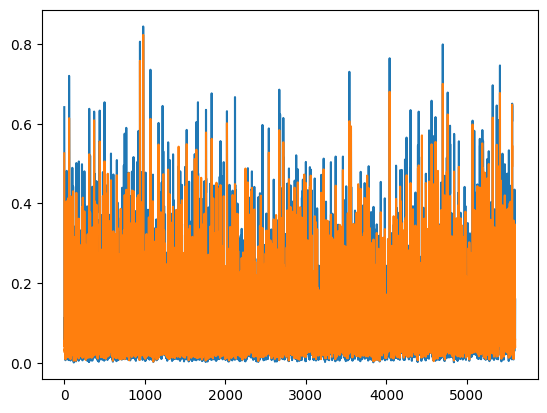

In [188]:
plt.plot(model_results.expectancies_npg)
plt.plot(model_results.expectancies_npxg)

In [189]:
#get poisson fit ll for npg model
ind_llres = get_log_likelihood(model_results.npg,
                               (model_results.expectancies_npg,), 
                               distribution='Poisson',
                               individual_scores=True)

llres = get_log_likelihood(model_results.npg,
                           (model_results.expectancies_npg,), 
                           distribution='Poisson',
                           individual_scores=False)

print(llres)
model_results["ll_poisson"] = ind_llres

(-1705.0193145457383, -0.3044677347403104)


In [190]:
#get poisson fit ll for npxg model
ind_llres = get_log_likelihood(model_results.npg,
                               (model_results.expectancies_npxg,), 
                               distribution='Poisson',
                               individual_scores=True)

llres = get_log_likelihood(model_results.npg,
                           (model_results.expectancies_npxg,), 
                           distribution='Poisson',
                           individual_scores=False)

print(llres)
model_results["ll_poisson"] = ind_llres

(-1697.3904903633854, -0.3031054447077474)


In [28]:
model = linear_model.PoissonRegressor(fit_intercept=False, alpha = 0, max_iter = 500)
model.fit(x_train, y_train)

PoissonRegressor(alpha=0, fit_intercept=False, max_iter=500)

In [30]:
y_pred = model.predict(x_val)
r2 = r2_score(y_pred=y_pred, y_true=y_val)
ll = get_log_likelihood(y_val, (y_pred,), distribution='Poisson',individual_scores=False)

In [31]:
print(ll)
print(r2)

(-2217.9160022553124, -0.2333665827288839)
0.24081785729420235


<AxesSubplot: >

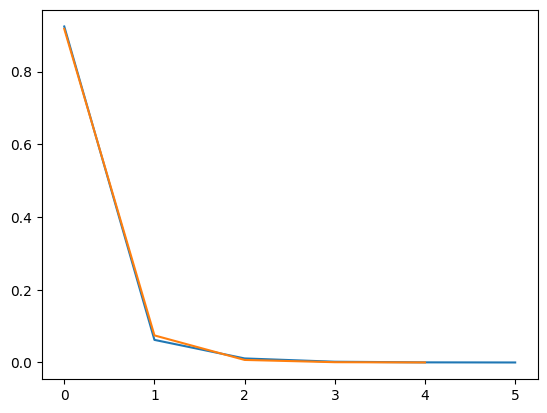

In [34]:
x = np.arange(0, 6)
probs= poisson.pmf(x, y_pred[:,np.newaxis])
probs_mean = np.mean(probs, axis=0)
plt.plot(x,probs_mean)
pd.Series(y_val).value_counts(normalize=True).sort_index().plot()

In [ ]:
df = pd.DataFrame({'feature':x.columns,'coef':model.coef_})

pl_coefs = df[df.feature.str.startswith("pl_")]
pl_coefs = pl_coefs.rename(columns={'feature':'player'})
pl_coefs["player"] = pl_coefs.player.transform(lambda x: x.replace("pl_",""))

gk_coefs = df[df.feature.str.startswith("gk_")]
gk_coefs = gk_coefs.rename(columns={'feature':'gk_opp'})
gk_coefs["gk_opp"] = gk_coefs.gk_opp.transform(lambda x: x.replace("gk_",""))


pl = pl_coefs.merge(xg_data, on=["player"]).sort_values(["conv_rate"],ascending=False)
gk = gk_coefs.merge(xg_gk_data, on=["gk_opp"]).sort_values(["conv_rate"],ascending=True)

In [ ]:
gk

In [ ]:
pl

In [ ]:
reg_grid = [0.005, 0.01, 0.05, 0.1]
decay_grid = [0.001,0.005,0.01,0.05]
grid_scores = tune_hyperparameters(train_data,reg_grid, decay_grid, features_to_use,target_var,
                         categorical_vars, encoding_dict,distribution="Poisson", lower_thresh= 10)

In [ ]:
reg_param = 0.005
decay_param = 0.001

iteration_results = get_consecutive_evaluations(None,train_data, decay_param, reg_param, features_to_use,target_var,
                                           categorical_vars,encoding_dict,distribution="Poisson",fit_intercept=False,
                                           lower_thresh=10,verbose=True)

In [ ]:
model_results = iteration_results.copy(deep=True)

In [ ]:
model_results = pd.merge(model_results,
                         val_data[["datetime","date","squad","position_mapped", "start", "player","npg"]],
                         on = ["date","squad","player"],
                         how='inner')

In [ ]:
model_results

In [ ]:
ind_llres = get_log_likelihood(model_results.npg,
                               (model_results.expectancies,), 
                               distribution='Poisson',
                               individual_scores=True)

llres = get_log_likelihood(model_results.npg,
                           (model_results.expectancies,), 
                           distribution='Poisson',
                           individual_scores=False)

r2score = r2_score(y_true=model_results.npg,y_pred= model_results.expectancies)
print(llres, r2score)
model_results["ll"] = ind_llres

In [ ]:
model_results[["npg","expectancies"]].corr()

In [ ]:
model_results.isnull().sum()